# Model Setup
Elementary set up and importing necessary libraries

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pickle
import statistics
import pandas as pd
import gzip
import json
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import pickle


from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import tqdm
import nltk
from google.colab import files

In [ ]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Use the same seed when using torch.cuda if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Use the same seed when using torch.backends.cudnn if available
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print("Using device:", device)

True
Using device: cuda


#Dataset Creation
Splitting dataset into training, validation and test set

In [ ]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Software_5.json.gz')

In [ ]:
from sklearn.utils import shuffle
df = df[['reviewText', 'overall']]
df = df.dropna()
df.isna().sum()
df = shuffle(df)
pickle.dump(df, open("processed_df.pkl", "wb"))

In [ ]:
df = pickle.load(open("processed_df.pkl", "rb"))
num_reviews = len(df)
idxs = list(range(num_reviews))

train_size = 0.3

test_idx = idxs[:int(0.1*num_reviews)]
val_idx = idxs[int(0.1*num_reviews):int(0.2*num_reviews)]
train_idx = idxs[int(0.2*num_reviews):int((0.2 + train_size)*num_reviews)]

df_train = df.iloc[train_idx][['reviewText', 'overall']].reset_index(drop=True)
df_val = df.iloc[val_idx][['reviewText', 'overall']].reset_index(drop=True)
df_test = df.iloc[test_idx][['reviewText', 'overall']].reset_index(drop=True)

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df.iloc[idx]

train_dataset = ReviewDataset(df_train)
test_dataset = ReviewDataset(df_test)
val_dataset = ReviewDataset(df_val)
dataset = ReviewDataset(df)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Transformers
Using pretrained DistilBERT to get embeddings of reviews.

In [ ]:
!pip install transformers
from transformers import get_linear_schedule_with_warmup
from tokenizers.processors import BertProcessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.1 MB/s eta 0:00:00


In [ ]:
bert_model_name = 'distilbert-base-uncased' 

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_model_name, num_labels = 5, output_hidden_states = True)
pretrained_bert = AutoModel.from_pretrained(bert_model_name)
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

In [ ]:
def transformer_collate_fn(batch, tokenizer):

  sentences, labels = [], []

  for data in batch:
    sentences.append(data['reviewText'])
    labels.append(data['overall'] - 1)

  tokenizer_output = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
  labels = F.one_hot(torch.tensor(labels).type(torch.LongTensor), num_classes=5).type(torch.FloatTensor)

  return tokenizer_output, labels

#Pretrained Model

In [ ]:
from functools import partial
dataloader = DataLoader(dataset, batch_size=16, collate_fn=partial(transformer_collate_fn, tokenizer=tokenizer))
sentence_embeddings = []

model = pretrained_bert.to(device)
model.eval()
with torch.no_grad():
  for batch in dataloader:
    input_tokens = batch[0].to(device)
    batch_sentence_embeddings = model(**input_tokens).last_hidden_state[:,0].cpu().numpy()
    del input_tokens
    sentence_embeddings.extend(batch_sentence_embeddings)

In [ ]:
X = np.array(sentence_embeddings)
y = np.array(df['overall']).astype('int32')
X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]

In [ ]:
pickle.dump(X, open("pretrained_bert_emb.pkl", "wb"))

In [ ]:
!cp -r "/content/pretrained_bert_emb.pkl" "/content/drive/MyDrive/NLP_Project_Sp23"

#Transformer Finetuning
Finetuning the DistilBERT model : Optimizing both the classifier head and the DistilBERT
parameters. 

In [ ]:
BATCH_SIZE = 32
LR = 5e-5
WEIGHT_DECAY = 0
N_EPOCHS = 5
CLIP = 1.0

In [ ]:
# Creating batched for model training
from functools import partial
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=partial(transformer_collate_fn, tokenizer=tokenizer))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=partial(transformer_collate_fn, tokenizer=tokenizer))
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=partial(transformer_collate_fn, tokenizer=tokenizer))

In [ ]:
from tqdm.notebook import trange, tqdm
def train(model, dataloader, opt, device, clip: float, scheduler = None):
  model.train()

  epoch_loss = 0.0
  progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}", leave=True)
  for batch in progress_bar:
      input, labels = batch[0], batch[1]

      input = input.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      output = model(**input, labels=labels)
      loss = output.loss
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
      
      optimizer.step()
      if scheduler is not None:
        scheduler.step()
        
      epoch_loss += loss.item()
      progress_bar.set_postfix({'loss': loss.item()})

  return epoch_loss / len(dataloader)

In [ ]:
#calculate the prediction accuracy on the provided dataloader
from sklearn.metrics import classification_report
def evaluate_acc(model,
                 dataloader,
                 device):

    model.eval()

    epoch_loss = 0
    with torch.no_grad():
      total_correct = 0
      total = 0

      complete_output = []
      complete_true = []
      for i, batch in enumerate(dataloader):
          
          input, labels = batch[0], batch[1]

          input = input.to(device)
          labels = labels.to(device)

          output = model(**input).logits
          output_class = torch.argmax(output, dim=1)
          true_class = torch.argmax(labels, dim=1)
          
          complete_output.extend(output_class.cpu().numpy())
          complete_true.extend(true_class.cpu().numpy())

          total_correct += torch.sum(torch.where(output_class == true_class.to(device), 1, 0))
          total += labels.size()[0]

    f.write(classification_report(complete_true, complete_output))
    print(classification_report(complete_true, complete_output))
    print(f"Total Correct = {total_correct}")
    return total_correct / total

In [ ]:
def evaluate(model,
                 dataloader,
                 device):

    model.eval()

    epoch_loss = 0
    with torch.no_grad():
      for i, batch in enumerate(dataloader):
          
          input, labels = batch[0], batch[1]

          input = input.to(device)
          labels = labels.to(device)

          output = model(**input, labels=labels)
          loss = output.loss
          epoch_loss += loss.item()
        
    return epoch_loss/len(dataloader)

In [ ]:
optimizer = optim.Adam(bert_model.parameters(), lr=LR)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=10, num_training_steps=N_EPOCHS*len(train_dataloader))
import time

bert_model = bert_model.to(device)
for params in bert_model.base_model.parameters():
    params.requires_grad = True

# print("Finetune the following parameters:")
# for name, params in bert_model.named_parameters():
#   if(params.requires_grad):
#     print(name)

f = open(f"BERT_FineTuning_{train_size}", "w")
for epoch in range(N_EPOCHS):
    f.write(f"Epoch {epoch}: \n \n")
    f.write("Train Classification Report: \n \n")
    train_loss = train(bert_model, train_dataloader, optimizer, device, CLIP, scheduler)
    train_acc = evaluate_acc(bert_model, train_dataloader, device)
    f.write("\n \n")
    f.write("Val Classification Report: \n \n")
    valid_loss = evaluate(bert_model, val_dataloader, device)
    valid_acc = evaluate_acc(bert_model, val_dataloader, device)
    f.write(f'\n \n \t Train Loss: {train_loss:.3f} \n')
    f.write(f'\t Train Acc: {train_acc:.3f} \n')
    f.write(f'\t Valid Loss: {valid_loss:.3f} \n')
    f.write(f'\t Valid Acc: {valid_acc:.3f} \n')

    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tTrain Acc: {train_acc:.3f}')
    print(f'\tValid Loss: {valid_loss:.3f}')
    print(f'\tValid Acc: {valid_acc:.3f}')

f.write("\n \n")
f.write("Test Classification Report: \n \n")
test_loss = evaluate(bert_model, test_dataloader, device)
test_acc = evaluate_acc(bert_model, test_dataloader, device)
f.write(f'\n \n \t Test Loss: {test_loss:.3f} \n')
f.write(f'\t Test Acc: {test_acc:.3f} \n')
f.close()

Epoch 1:   0%|          | 0/121 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.39      0.90      0.55       455
           1       0.00      0.00      0.00       213
           2       0.40      0.01      0.02       496
           3       0.46      0.39      0.42       867
           4       0.75      0.85      0.80      1811

    accuracy                           0.60      3842
   macro avg       0.40      0.43      0.36      3842
weighted avg       0.56      0.60      0.54      3842

Total Correct = 2292
              precision    recall  f1-score   support

           0       0.39      0.87      0.53       150
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00       173
           3       0.43      0.35      0.38       304
           4       0.70      0.83      0.76       587

    accuracy                           0.56      1280
   macro avg       0.30      0.41      0.33      1280
weighted avg       0.47      0.56      0.50      1280

T

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

Epoch 2:   0%|          | 0/121 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.68      0.91      0.78       455
           1       0.00      0.00      0.00       213
           2       0.57      0.54      0.56       496
           3       0.64      0.61      0.62       867
           4       0.85      0.91      0.87      1811

    accuracy                           0.74      3842
   macro avg       0.55      0.59      0.57      3842
weighted avg       0.70      0.74      0.72      3842

Total Correct = 2848
              precision    recall  f1-score   support

           0       0.61      0.74      0.67       150
           1       0.00      0.00      0.00        66
           2       0.44      0.39      0.41       173
           3       0.46      0.44      0.45       304
           4       0.75      0.84      0.79       587

    accuracy                           0.63      1280
   macro avg       0.45      0.48      0.47      1280
weighted avg       0.59      0.63      0.61      1280

T

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

Epoch 3:   0%|          | 0/121 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.73      0.97      0.83       455
           1       0.00      0.00      0.00       213
           2       0.69      0.71      0.70       496
           3       0.81      0.69      0.75       867
           4       0.89      0.97      0.93      1811

    accuracy                           0.82      3842
   macro avg       0.62      0.67      0.64      3842
weighted avg       0.78      0.82      0.80      3842

Total Correct = 3159
              precision    recall  f1-score   support

           0       0.63      0.75      0.69       150
           1       0.00      0.00      0.00        66
           2       0.45      0.45      0.45       173
           3       0.49      0.38      0.43       304
           4       0.74      0.87      0.80       587

    accuracy                           0.64      1280
   macro avg       0.46      0.49      0.47      1280
weighted avg       0.59      0.64      0.61      1280

T

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

Epoch 4:   0%|          | 0/121 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.78      0.98      0.87       455
           1       0.80      0.02      0.04       213
           2       0.75      0.88      0.81       496
           3       0.91      0.89      0.90       867
           4       0.96      0.97      0.97      1811

    accuracy                           0.89      3842
   macro avg       0.84      0.75      0.72      3842
weighted avg       0.89      0.89      0.87      3842

Total Correct = 3417
              precision    recall  f1-score   support

           0       0.63      0.68      0.66       150
           1       0.75      0.05      0.09        66
           2       0.41      0.47      0.44       173
           3       0.50      0.51      0.51       304
           4       0.78      0.81      0.80       587

    accuracy                           0.64      1280
   macro avg       0.62      0.50      0.50      1280
weighted avg       0.65      0.64      0.63      1280

T

Epoch 5:   0%|          | 0/121 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       455
           1       0.85      0.05      0.10       213
           2       0.74      0.91      0.81       496
           3       0.93      0.91      0.92       867
           4       0.97      0.98      0.97      1811

    accuracy                           0.90      3842
   macro avg       0.87      0.77      0.74      3842
weighted avg       0.91      0.90      0.88      3842

Total Correct = 3475
              precision    recall  f1-score   support

           0       0.67      0.66      0.67       150
           1       0.00      0.00      0.00        66
           2       0.41      0.49      0.45       173
           3       0.50      0.49      0.50       304
           4       0.77      0.82      0.80       587

    accuracy                           0.64      1280
   macro avg       0.47      0.49      0.48      1280
weighted avg       0.61      0.64      0.62      1280

T

In [ ]:
from functools import partial
dataloader = DataLoader(dataset, batch_size=16, collate_fn=partial(transformer_collate_fn, tokenizer=tokenizer))
ft_sentence_embeddings = []

model = bert_model
torch.cuda.empty_cache()
model = model.to(device)
model.eval()
with torch.no_grad():
  for batch in dataloader:
    input_tokens = batch[0].to(device)
    batch_sentence_embeddings = model(**input_tokens).hidden_states[-1][:,0].cpu().numpy()
    del input_tokens
    ft_sentence_embeddings.extend(batch_sentence_embeddings)

In [ ]:
ft_sentence_embeddings = np.array(ft_sentence_embeddings)
pickle.dump(ft_sentence_embeddings, open(f"finetuned_bert_emb_{int(100 * train_size)}.pkl", "wb"))

#Graph Creation
A document-word graph is constructed. Every document (review) and word in the dataset is represented as a node in the graph. We calculate the term frequency - inverse document frequency (tf-idf ) scores for all words across all documents.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures

In [ ]:
df = pickle.load(open("processed_df.pkl", "rb"))
reviews = df['reviewText'].dropna().tolist()
tfidf = TfidfVectorizer()
vectorizer = tfidf.fit_transform(reviews)
v = vectorizer.toarray()
i2word = {_v + v.shape[0] : k for k, _v in tfidf.vocabulary_.items()}
word2i = {k : _v + v.shape[0] for k, _v in tfidf.vocabulary_.items()}

In [ ]:
_v = []
tot = 0

for i in range(v.shape[0]):
    __v = v[i]
    __v = __v[__v > 0.]
    __v = np.sort(__v)
    len_v = int(__v.shape[0] * 0.6)
    tot += (__v.shape[0] - len_v)
    if __v.shape[0] > len_v:
        threshold = __v[len_v]
        _v.append(threshold)
_v = np.sort(np.array(_v))
t = _v[int(_v.shape[0]*0.6)]
for i in range(v.shape[0]):
    __v = v[i]
    __v = __v[__v > t]
    tot += __v.shape[0]
graph = []

w_graph = []

for i in range(v.shape[0]):
    doc = v[i]
    for token in np.argwhere(doc > t):
        token = token.item()
        graph.append((i, token+v.shape[0], doc[token]))
        graph.append((token+v.shape[0], i, doc[token]))

        w_graph.append((token+v.shape[0], i, doc[token]))
        
g = {'graph' : graph, 'i2word' : i2word, 'word2i' : word2i}

with open('graph_no_words.pkl', 'wb') as f:
    pickle.dump(g, f)

Graph Convolutional Network (GCN)
architecture for a node classification task using Py-
Torch Geometric library. The GCN model uses a 2
layer message passing network, with an hidden di-
mension of size 300. Each layer of the GCN takes
as input the node features, and the set of edges in
the graph, and outputs a new set of node features by
(non-linear) aggregating information from the neigh-
borhood of each node in the document-word graph.
The output of the last layer of the GCN model is the
learnt node embeddings, and we use the document
node embeddings for the text classification task. We
analyse the performance of the GCN model for two
different initialization techniques: (1) Using the pre-
trained DistilBERT model, and (2) Using the fine-
tuned DistilBERT model.

#GCN- Pretrained


In [ ]:
# No word-word edges
graph  = pickle.load(open("graph.pkl", "rb"))
edges = graph['graph']
vocab = graph['vocab_dict']
num_docs = len(df)

source = []
dest = []
scores = []
edge_index = []
edge_attr = []

reduced_vocab = {}

for i, e in enumerate(edges):
  for r in e:
    if(r[2] > 0.0):
      source.append(r[0])
      dest.append(r[1][0])
      scores.append(r[2])

      x = r[1][0]

      if(x in reduced_vocab.keys()):
        y = reduced_vocab[x]
      else:
        reduced_vocab[x] = len(reduced_vocab)
        y = reduced_vocab[x]

      edge_index.append([r[0], num_docs + y])
      edge_index.append([num_docs + y, r[0]])
      edge_attr.append(r[2])
      edge_attr.append(r[2])

num_words = len(reduced_vocab)

initial_embeddings = torch.rand(num_docs + num_words, 768)
edge_index = torch.transpose(torch.tensor(edge_index), 1, 0)
edge_attr = torch.transpose(torch.tensor(edge_attr), 1, 0)
num_words, edge_index.size(), edge_attr.size()

<ipython-input-23-8d19cd6a920f>:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  edge_attr = torch.transpose(torch.tensor(edge_attr), 1, 0)


(15996, torch.Size([2, 350720]), torch.Size([1, 350720]))

In [ ]:
select_words = []
for global_word_id in reduced_vocab.keys():
  select_words.append(vocab[global_word_id])
select_words = pd.DataFrame(select_words, columns=['reviewText'])

In [ ]:
from functools import partial

def transformer_collate_fn_red(batch, tokenizer):
  sentences = []

  for data in batch:
    sentences.append(data['reviewText'])

  tokenizer_output = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
  return tokenizer_output

com_df = ReviewDataset(select_words)
dataloader = DataLoader(com_df, batch_size=16, collate_fn=partial(transformer_collate_fn_red, tokenizer=tokenizer))
com_embeddings = []

model = pretrained_bert.to(device)
model.eval()
with torch.no_grad():
  for batch in dataloader:
    input_tokens = batch.to(device)
    batch_com_embeddings = model(**input_tokens).last_hidden_state[:,0].cpu().numpy()
    del input_tokens
    com_embeddings.extend(batch_com_embeddings)

In [ ]:
num_docs, num_words
# fbert = pickle.load(open("finetuned_bert_emb_10.pkl", "rb"))
pbert = pickle.load(open("pretrained_bert_emb.pkl", "rb"))
com_emb = np.zeros((num_docs + num_words, 768)).astype(np.float64)
com_emb[:num_docs] = pbert
com_emb[num_docs:] = com_embeddings

In [ ]:
class GraphData():
  def __init__(self, initial_embeddings = None, edge_index = None, edge_attr = None, train_mask = None, val_mask = None, test_mask = None):
    
    self.initial_embeddings = initial_embeddings
    self.edge_index = edge_index
    self.edge_attr = edge_attr

    self.train_mask = train_mask
    self.val_mask = val_mask
    self.test_mask = test_mask

    self.X = None
    self.y = None

initial_embeddings = torch.from_numpy(np.array(com_emb)).type(torch.float)
data = GraphData(initial_embeddings, edge_index, edge_attr)

In [ ]:
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 69.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Note: You will be using the GCNConv to implement a graph convolution layer
from torch_geometric.nn import GCNConv 

class GCN(torch.nn.Module):
    def __init__(self, data, hidden_channels, dropout_probability):
        super().__init__()

        self.data = data
        # Check dimensions?
        self.input_size = self.data.initial_embeddings.size()[1]
        self.dropout_p = dropout_probability

        self.conv1 = GCNConv(self.input_size, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = nn.Dropout(p=self.dropout_p)
        
        self.output_edge = torch.nn.Linear(2 * hidden_channels, 1)
        self.output_class = torch.nn.Linear(hidden_channels, 5)

    def forward(self, data):
        out = None

        node_features = data.initial_embeddings # from BERT
        edge_index = data.edge_index
        edge_attr = data.edge_attr

        out = torch.nn.ReLU()(self.conv1(node_features, edge_index))
        out = self.dropout(out)
        out = self.conv2(out, edge_index)
        # out = torch.nn.ReLU()(self.conv2(out, edge_index))
        # out = self.dropout(out)
        # out = self.conv3(out, edge_index)

        return out
    
    def predict_proba(self, data, mask):
        node_emb = self.forward(data)
        node_pairs = data.X[:, mask==1]
        node_pair_emb = torch.cat((node_emb[node_pairs[0,:]], node_emb[node_pairs[1,:]]), dim=1)
        logit = self.output_edge(node_pair_emb)
        prob = torch.sigmoid(logit).squeeze()
        #########################################
        return prob
    
    def predict_class(self, data, mask):
        node_emb = self.forward(data)[mask]
        node_emb = torch.nn.ReLU()(node_emb)
        prob = self.output_class(node_emb)
        return prob

In [ ]:
# Hyperparameters of the model. DO NOT CHANGE.
input_size = 768
hidden_channels = 300
dropout_probability = 0.2

gcn_model = GCN(data, hidden_channels=hidden_channels, dropout_probability=dropout_probability)
print(gcn_model)

GCN(
  (conv1): GCNConv(768, 300)
  (conv2): GCNConv(300, 300)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_edge): Linear(in_features=600, out_features=1, bias=True)
  (output_class): Linear(in_features=300, out_features=5, bias=True)
)


In [ ]:
def train_lp (model, data, criterion1, criterion2, optimizer, pos_weight = 1, neg_weight=1, class_weight=1):
    model.train()
    optimizer.zero_grad()
    train_pos_loss, train_neg_loss = None, None

    # y_pred = model.predict_proba(data, data.train_mask)
    # y_train = data.y[data.train_mask==1]
    # pos_edge_pred = y_pred[y_train == 1]
    # neg_edge_pred = y_pred[y_train == 0] 

    # print(pos_edge_pred.size())

    # train_pos_loss = criterion1(pos_edge_pred, torch.ones(pos_edge_pred.shape[0], dtype=torch.float))
    # print(f"Positive Loss", train_pos_loss, pos_edge_pred)
    # train_neg_loss = criterion1(neg_edge_pred, torch.zeros(neg_edge_pred.shape[0], dtype=torch.float))
    # print(f"Negative Loss", train_neg_loss, neg_edge_pred)

    y_pred_class = model.predict_class(data, train_idx)
    labels = torch.from_numpy(np.array(df['overall']-1)[train_idx]).type(torch.LongTensor)
    class_loss = criterion2(y_pred_class, labels)

    # print(f"Positive Loss = {train_pos_loss.item()}")
    # print(f"Negative Loss = {train_neg_loss.item()}")
    # print(f"Class Loss = {class_loss.item()}")

    # loss = pos_weight * train_pos_loss + neg_weight * train_neg_loss + class_weight * class_loss
    loss = class_loss
    loss.backward()
    optimizer.step()
    #########################################
    return loss.detach().cpu()

In [ ]:
# Validate the model on a held-out validataion dataset. We will reuse this function for GCN too.
def validate_lp (model, data, criterion1, criterion2, pos_weight = 1, neg_weight=1, class_weight=1):
    model.eval()
    val_loss = None
    with torch.no_grad():
      
        # y_pred = model.predict_proba(data, data.val_mask)
        # y_val = data.y[data.val_mask == 1]
        # pos_edge_pred = y_pred[y_val == 1]
        # neg_edge_pred = y_pred[y_val == 0] 

        # val_pos_loss = criterion1(pos_edge_pred, torch.ones(pos_edge_pred.shape[0], dtype=torch.float))
        # val_neg_loss = criterion1(neg_edge_pred, torch.zeros(neg_edge_pred.shape[0], dtype=torch.float))

        y_pred_class = model.predict_class(data, val_idx)
        labels = torch.from_numpy(np.array(df['overall']-1)[val_idx]).type(torch.LongTensor)
        class_loss = criterion2(y_pred_class, labels)

        # val_loss = pos_weight * val_pos_loss + neg_weight * val_neg_loss + class_weight * class_loss
        val_loss = class_loss
        #########################################
    return val_loss.cpu()

In [ ]:
# Let us train this model.

# Hyperparameters of the model. DO NOT CHANGE.
num_epochs = 100 # Number of epochs
lr = 0.01 # learning rate, also called step size sometimes
wd = 1e-4 # Weight decay, regularization parameter (ensures that we don't overfit to the training data)

gcn_model = GCN(data, hidden_channels=hidden_channels, dropout_probability=dropout_probability).float()
criterion1 = torch.nn.BCELoss()
criterion2 = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(gcn_model.parameters(), lr=lr, weight_decay=wd)

training_loss = []
validation_loss = []

for epoch in range(1, num_epochs+1):
    train_loss = train_lp (gcn_model, data, criterion1, criterion2, optimizer, 0, 0, 1)
    val_loss = validate_lp (gcn_model, data, criterion1, criterion2, 0, 0, 1)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    # train_loss = sum(train_loss)
    # Print loss values every 10 epochs
    if epoch%10 == 0:
      print(f'Epoch: {epoch:03d}, Training Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f}')

Epoch: 010, Training Loss: 1.4182 Validation Loss: 1.4177
Epoch: 020, Training Loss: 1.3847 Validation Loss: 1.3907
Epoch: 030, Training Loss: 1.3787 Validation Loss: 1.3842
Epoch: 040, Training Loss: 1.3773 Validation Loss: 1.3816
Epoch: 050, Training Loss: 1.3755 Validation Loss: 1.3803
Epoch: 060, Training Loss: 1.3757 Validation Loss: 1.3796
Epoch: 070, Training Loss: 1.3750 Validation Loss: 1.3792
Epoch: 080, Training Loss: 1.3750 Validation Loss: 1.3788
Epoch: 090, Training Loss: 1.3756 Validation Loss: 1.3786
Epoch: 100, Training Loss: 1.3751 Validation Loss: 1.3786


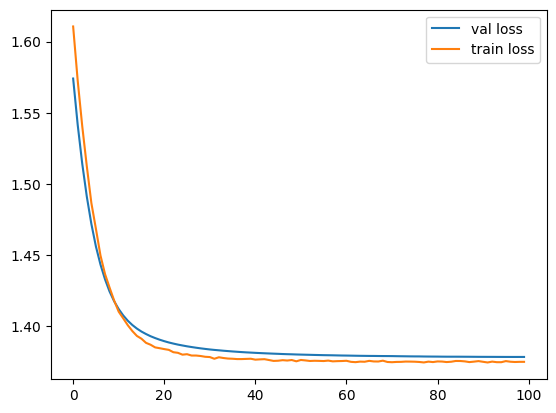

In [ ]:
# pos_loss, neg_loss, train_loss = [], [], []

# for l in training_loss:
#   pos_loss.append(l[0])
#   neg_loss.append(l[1])
#   train_loss.append(l[0] + l[1])

import matplotlib.pyplot as plt

e = np.arange(len(training_loss))
# plt.plot(e, pos_loss, label='pos loss')
# plt.plot(e, neg_loss, label='neg loss')
plt.plot(e, validation_loss, label='val loss')
plt.plot(e, training_loss, label='train loss')
plt.legend()
plt.show()

In [ ]:
doc_node_embeddings = gcn_model.forward(data)[:num_docs, :].detach().numpy()

In [ ]:
pickle.dump(doc_node_embeddings, open("pretrained_graph_embeddings.pkl", "wb"))

# GCN-Finetuned

In [ ]:
# No word-word edges
graph  = pickle.load(open("graph.pkl", "rb"))
edges = graph['graph']
vocab = graph['vocab_dict']
num_docs = len(df)

source = []
dest = []
scores = []
edge_index = []
edge_attr = []

reduced_vocab = {}

for i, e in enumerate(edges):
  for r in e:
    if(r[2] > 0.0):
      source.append(r[0])
      dest.append(r[1][0])
      scores.append(r[2])

      x = r[1][0]

      if(x in reduced_vocab.keys()):
        y = reduced_vocab[x]
      else:
        reduced_vocab[x] = len(reduced_vocab)
        y = reduced_vocab[x]

      edge_index.append([r[0], num_docs + y])
      edge_index.append([num_docs + y, r[0]])
      edge_attr.append(r[2])
      edge_attr.append(r[2])

num_words = len(reduced_vocab)

initial_embeddings = torch.rand(num_docs + num_words, 768)
edge_index = torch.transpose(torch.tensor(edge_index), 1, 0)
edge_attr = torch.transpose(torch.tensor(edge_attr), 1, 0)
num_words, edge_index.size(), edge_attr.size()

(15996, torch.Size([2, 350720]), torch.Size([1, 350720]))

In [ ]:
select_words = []
for global_word_id in reduced_vocab.keys():
  select_words.append(vocab[global_word_id])
select_words = pd.DataFrame(select_words, columns=['reviewText'])

In [ ]:
from functools import partial

def transformer_collate_fn_red(batch, tokenizer):
  sentences = []

  for data in batch:
    sentences.append(data['reviewText'])

  tokenizer_output = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
  return tokenizer_output

com_df = ReviewDataset(select_words)
dataloader = DataLoader(com_df, batch_size=16, collate_fn=partial(transformer_collate_fn_red, tokenizer=tokenizer))
com_embeddings = []

model = pretrained_bert.to(device)
model.eval()
with torch.no_grad():
  for batch in dataloader:
    input_tokens = batch.to(device)
    batch_com_embeddings = model(**input_tokens).last_hidden_state[:,0].cpu().numpy()
    del input_tokens
    com_embeddings.extend(batch_com_embeddings)

In [ ]:
num_docs, num_words
fbert = pickle.load(open("finetuned_bert_emb_30.pkl", "rb"))
# pbert = pickle.load(open("pretrained_bert_emb.pkl", "rb"))
com_emb = np.zeros((num_docs + num_words, 768)).astype(np.float64)
com_emb[:num_docs] = fbert
com_emb[num_docs:] = com_embeddings

In [ ]:
class GraphData():
  def __init__(self, initial_embeddings = None, edge_index = None, edge_attr = None, train_mask = None, val_mask = None, test_mask = None):
    
    self.initial_embeddings = initial_embeddings
    self.edge_index = edge_index
    self.edge_attr = edge_attr

    self.train_mask = train_mask
    self.val_mask = val_mask
    self.test_mask = test_mask

    self.X = None
    self.y = None

initial_embeddings = torch.from_numpy(np.array(com_emb)).type(torch.float)
data = GraphData(initial_embeddings, edge_index, edge_attr)

In [ ]:
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Note: You will be using the GCNConv to implement a graph convolution layer
from torch_geometric.nn import GCNConv 

class GCN(torch.nn.Module):
    def __init__(self, data, hidden_channels, dropout_probability):
        super().__init__()

        self.data = data
        # Check dimensions?
        self.input_size = self.data.initial_embeddings.size()[1]
        self.dropout_p = dropout_probability

        self.conv1 = GCNConv(self.input_size, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = nn.Dropout(p=self.dropout_p)
        
        self.output_edge = torch.nn.Linear(2 * hidden_channels, 1)
        self.output_class = torch.nn.Linear(hidden_channels, 5)

    def forward(self, data):
        out = None

        node_features = data.initial_embeddings # from BERT
        edge_index = data.edge_index
        edge_attr = data.edge_attr

        out = torch.nn.ReLU()(self.conv1(node_features, edge_index))
        out = self.dropout(out)
        out = self.conv2(out, edge_index)
        # out = torch.nn.ReLU()(self.conv2(out, edge_index))
        # out = self.dropout(out)
        # out = self.conv3(out, edge_index)

        return out
    
    def predict_proba(self, data, mask):
        node_emb = self.forward(data)
        node_pairs = data.X[:, mask==1]
        node_pair_emb = torch.cat((node_emb[node_pairs[0,:]], node_emb[node_pairs[1,:]]), dim=1)
        logit = self.output_edge(node_pair_emb)
        prob = torch.sigmoid(logit).squeeze()
        #########################################
        return prob
    
    def predict_class(self, data, mask):
        node_emb = self.forward(data)[mask]
        node_emb = torch.nn.ReLU()(node_emb)
        prob = self.output_class(node_emb)
        return prob

In [ ]:
# Hyperparameters of the model. DO NOT CHANGE.
input_size = 768
hidden_channels = 300
dropout_probability = 0.2

gcn_model = GCN(data, hidden_channels=hidden_channels, dropout_probability=dropout_probability)
print(gcn_model)

GCN(
  (conv1): GCNConv(768, 300)
  (conv2): GCNConv(300, 300)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_edge): Linear(in_features=600, out_features=1, bias=True)
  (output_class): Linear(in_features=300, out_features=5, bias=True)
)


In [ ]:
def train_lp (model, data, criterion1, criterion2, optimizer, pos_weight = 1, neg_weight=1, class_weight=1):
    model.train()
    optimizer.zero_grad()
    train_pos_loss, train_neg_loss = None, None

    # y_pred = model.predict_proba(data, data.train_mask)
    # y_train = data.y[data.train_mask==1]
    # pos_edge_pred = y_pred[y_train == 1]
    # neg_edge_pred = y_pred[y_train == 0] 

    # print(pos_edge_pred.size())

    # train_pos_loss = criterion1(pos_edge_pred, torch.ones(pos_edge_pred.shape[0], dtype=torch.float))
    # print(f"Positive Loss", train_pos_loss, pos_edge_pred)
    # train_neg_loss = criterion1(neg_edge_pred, torch.zeros(neg_edge_pred.shape[0], dtype=torch.float))
    # print(f"Negative Loss", train_neg_loss, neg_edge_pred)

    y_pred_class = model.predict_class(data, train_idx)
    labels = torch.from_numpy(np.array(df['overall']-1)[train_idx]).type(torch.LongTensor)
    class_loss = criterion2(y_pred_class, labels)

    # print(f"Positive Loss = {train_pos_loss.item()}")
    # print(f"Negative Loss = {train_neg_loss.item()}")
    # print(f"Class Loss = {class_loss.item()}")

    # loss = pos_weight * train_pos_loss + neg_weight * train_neg_loss + class_weight * class_loss
    loss = class_loss
    loss.backward()
    optimizer.step()
    #########################################
    return loss.detach().cpu()

In [ ]:
# Validate the model on a held-out validataion dataset. We will reuse this function for GCN too.
def validate_lp (model, data, criterion1, criterion2, pos_weight = 1, neg_weight=1, class_weight=1):
    model.eval()
    val_loss = None
    with torch.no_grad():
      
        # y_pred = model.predict_proba(data, data.val_mask)
        # y_val = data.y[data.val_mask == 1]
        # pos_edge_pred = y_pred[y_val == 1]
        # neg_edge_pred = y_pred[y_val == 0] 

        # val_pos_loss = criterion1(pos_edge_pred, torch.ones(pos_edge_pred.shape[0], dtype=torch.float))
        # val_neg_loss = criterion1(neg_edge_pred, torch.zeros(neg_edge_pred.shape[0], dtype=torch.float))

        y_pred_class = model.predict_class(data, val_idx)
        labels = torch.from_numpy(np.array(df['overall']-1)[val_idx]).type(torch.LongTensor)
        class_loss = criterion2(y_pred_class, labels)

        # val_loss = pos_weight * val_pos_loss + neg_weight * val_neg_loss + class_weight * class_loss
        val_loss = class_loss
        #########################################
    return val_loss.cpu()

In [ ]:
# Let us train this model.

# Hyperparameters of the model. DO NOT CHANGE.
num_epochs = 100 # Number of epochs
lr = 0.01 # learning rate, also called step size sometimes
wd = 1e-4 # Weight decay, regularization parameter (ensures that we don't overfit to the training data)

gcn_model = GCN(data, hidden_channels=hidden_channels, dropout_probability=dropout_probability).float()
criterion1 = torch.nn.BCELoss()
criterion2 = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(gcn_model.parameters(), lr=lr, weight_decay=wd)

training_loss = []
validation_loss = []

for epoch in range(1, num_epochs+1):
    train_loss = train_lp (gcn_model, data, criterion1, criterion2, optimizer, 0, 0, 1)
    val_loss = validate_lp (gcn_model, data, criterion1, criterion2, 0, 0, 1)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    # train_loss = sum(train_loss)
    # Print loss values every 10 epochs
    if epoch%10 == 0:
      print(f'Epoch: {epoch:03d}, Training Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f}')

Epoch: 010, Training Loss: 1.4755 Validation Loss: 1.4697
Epoch: 020, Training Loss: 1.3949 Validation Loss: 1.4037
Epoch: 030, Training Loss: 1.3690 Validation Loss: 1.3814
Epoch: 040, Training Loss: 1.3569 Validation Loss: 1.3710
Epoch: 050, Training Loss: 1.3492 Validation Loss: 1.3647
Epoch: 060, Training Loss: 1.3441 Validation Loss: 1.3603
Epoch: 070, Training Loss: 1.3391 Validation Loss: 1.3569
Epoch: 080, Training Loss: 1.3351 Validation Loss: 1.3538
Epoch: 090, Training Loss: 1.3311 Validation Loss: 1.3510
Epoch: 100, Training Loss: 1.3265 Validation Loss: 1.3482


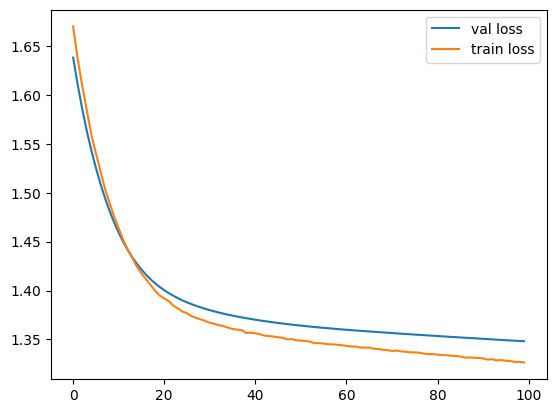

In [ ]:
# pos_loss, neg_loss, train_loss = [], [], []

# for l in training_loss:
#   pos_loss.append(l[0])
#   neg_loss.append(l[1])
#   train_loss.append(l[0] + l[1])

import matplotlib.pyplot as plt

e = np.arange(len(training_loss))
# plt.plot(e, pos_loss, label='pos loss')
# plt.plot(e, neg_loss, label='neg loss')
plt.plot(e, validation_loss, label='val loss')
plt.plot(e, training_loss, label='train loss')
plt.legend()
plt.show()

In [ ]:
doc_node_embeddings = gcn_model.forward(data)[:num_docs, :].detach().numpy()

In [ ]:
pickle.dump(doc_node_embeddings, open("finetuned_graph_embeddings.pkl", "wb"))

# GCN + BERT
The proposed BERTG model captures both the local structural information, and the contextual information by combining the BERT and the GCN model.

In [ ]:
class Embedding_classifier(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super().__init__()
        self.lin1 = torch.nn.Linear(input_size, input_size)
        self.lin2 = torch.nn.Linear(input_size, 5)
        # self.lin3 = torch.nn.Linear(30, 5)
        self.dropout = torch.nn.Dropout(p = 0.2)
        # self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.nn.ReLU()(x)
        x = self.dropout(x)
        x = self.lin2(x)
        # x = torch.nn.ReLU()(x)
        # x = self.dropout(x)
        # x = self.lin3(x)
        # x = self.sm(self.lin2(x))
        return x

The document node embeddings learnt by the GCN model is concatenated with the embeddings of the ‘[CLS]’ token from the last hidden state of the BERT model

In [ ]:
# Dataset Creating for cls training

class CustomDataset(Dataset):
    def __init__(self, X, y, sample_weight):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.long) # Change 1-5 to 0-4
        self.sample_weights = torch.tensor(sample_weight, dtype=torch.float)
        print(self.X.size(), self.y.size(), self.sample_weights.size())
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return torch.tensor(self.X[index]), torch.tensor(self.y[index]), torch.tensor(self.sample_weights[index])

fbert = pickle.load(open("finetuned_bert_emb_30.pkl", "rb"))
pbert = pickle.load(open("pretrained_bert_emb.pkl", "rb"))
grp = pickle.load(open("pretrained_graph_embeddings.pkl", "rb"))
grf =  pickle.load(open("finetuned_graph_embeddings.pkl", "rb"))
combined = np.concatenate((fbert, grf), axis=1)
emb = combined
# emb = doc_node_embeddings
X = np.array(emb).astype('float')
y = np.array(df['overall'] - 1).astype('int32')

from torch.utils.data import WeightedRandomSampler
class_freq = np.bincount(y)
class_weights = 1.0/class_freq
sample_weights = class_weights[y]

X_train, y_train, sw_train = X[train_idx, :], y[train_idx], sample_weights[train_idx]
X_val, y_val, sw_val = X[val_idx, :], y[val_idx], sample_weights[val_idx]
X_test, y_test, sw_test = X[test_idx, :], y[test_idx], sample_weights[test_idx]

train_dataset = CustomDataset(X_train, y_train, sw_train)
val_dataset = CustomDataset(X_val, y_val, sw_val)
test_dataset = CustomDataset(X_test, y_test, sw_test)

sampler = WeightedRandomSampler(sw_train, len(sw_train))
train_dataloader = DataLoader(train_dataset, batch_size=16)#, sampler=sampler)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=16)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=16)

torch.Size([3842, 1068]) torch.Size([3842]) torch.Size([3842])
torch.Size([1280, 1068]) torch.Size([1280]) torch.Size([1280])
torch.Size([1280, 1068]) torch.Size([1280]) torch.Size([1280])


The concatenated embedding is passed to an MLP for classification. We use a categorical cross entropy loss function, with the AdamW optimizer, and a batch size of 16 for training the model parameters. The learning rate, weight decay, and number of epochs are optimized for each model. 

In [ ]:
cls = Embedding_classifier(X_train.shape[1], 300)

criterion = torch.nn.CrossEntropyLoss()#weight = torch.tensor([1, 1, 1, 2, 1], dtype=torch.float))
optimizer = optim.Adam(cls.parameters(), lr=1e-5)

train_loss = []
val_loss = []

for epoch in range(1, 141):
  print(f"Epoch: {epoch}")
  total_correct = 0
  epoch_loss = 0.0
  total = 0
  class_dist = []
  
  for data in train_dataloader:
    input, labels, _ = data

    optimizer.zero_grad()

    pred = cls(input)
    loss = criterion(pred, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    y_pred_class = torch.argmax(pred, dim=1)
    class_dist.extend(y_pred_class.detach().cpu().numpy())

    total_correct += torch.sum(torch.where(y_pred_class == labels, 1, 0))
    total += labels.size()[0]

  train_loss.append(epoch_loss)
  print(f"\t Train Loss = {epoch_loss}")
  print(f"\t Train Accuracy = {total_correct/total}")

  total_correct = 0
  total = 0
  epoch_loss = 0.0

  for data in val_dataloader:
    input, labels, _ = data

    with torch.no_grad():
      pred = cls(input)
      loss = criterion(pred, labels)

    epoch_loss += loss.item()

    y_pred_class = torch.argmax(pred, dim=1)
    total_correct += torch.sum(torch.where(y_pred_class == labels, 1, 0))
    total += labels.size()[0]

  val_loss.append(epoch_loss)
  print(f"\t Val Loss = {epoch_loss}")
  print(f"\t Val Accuracy = {total_correct/total}")

Epoch: 1


<ipython-input-74-18ae3b36195f>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[index]), torch.tensor(self.y[index]), torch.tensor(self.sample_weights[index])


	 Train Loss = 170.26924945414066
	 Train Accuracy = 0.8656949400901794
	 Val Loss = 80.17698153853416
	 Val Accuracy = 0.632031261920929
Epoch: 2
	 Train Loss = 72.71040827780962
	 Train Accuracy = 0.9133263826370239
	 Val Loss = 89.02640029788017
	 Val Accuracy = 0.6328125
Epoch: 3
	 Train Loss = 60.64054114744067
	 Train Accuracy = 0.9289432764053345
	 Val Loss = 95.74252600967884
	 Val Accuracy = 0.633593738079071
Epoch: 4
	 Train Loss = 56.920978201553226
	 Train Accuracy = 0.9289432764053345
	 Val Loss = 100.03355917334557
	 Val Accuracy = 0.6304687261581421
Epoch: 5
	 Train Loss = 55.24503641575575
	 Train Accuracy = 0.9292035102844238
	 Val Loss = 102.7697634100914
	 Val Accuracy = 0.6273437738418579
Epoch: 6
	 Train Loss = 54.0771833602339
	 Train Accuracy = 0.9305049180984497
	 Val Loss = 104.44270527362823
	 Val Accuracy = 0.6304687261581421
Epoch: 7
	 Train Loss = 53.59223144128919
	 Train Accuracy = 0.9305049180984497
	 Val Loss = 106.38034254312515
	 Val Accuracy = 0.6265

              precision    recall  f1-score   support

           0     0.6250    0.7983    0.7011       119
           1     0.3544    0.3544    0.3544        79
           2     0.4600    0.4662    0.4631       148
           3     0.4968    0.4685    0.4822       333
           4     0.7795    0.7587    0.7690       601

    accuracy                         0.6281      1280
   macro avg     0.5431    0.5692    0.5540      1280
weighted avg     0.6284    0.6281    0.6271      1280



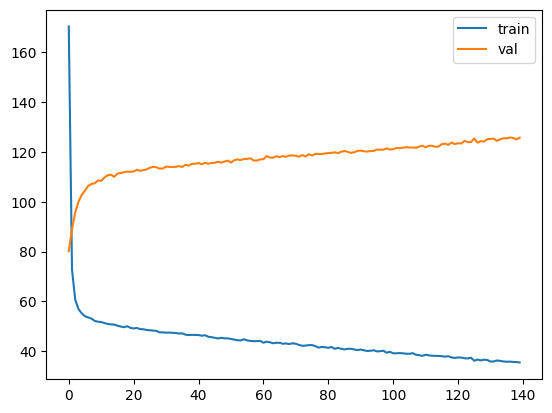

In [ ]:
y_test_pred = cls(torch.tensor(X_test, dtype=torch.float))
y_test_pred = torch.argmax(y_test_pred, dim=1)
from sklearn.metrics import classification_report
print(classification_report(y_test_pred, y_test, digits=4))

import matplotlib.pyplot as plt
e = np.arange(len(train_loss))
plt.plot(e, train_loss, label='train')
plt.plot(e, val_loss, label='val')
plt.legend()
plt.show()